In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
data_dir = '/content/drive/MyDrive/our_faces'

train_dir = os.path.join(data_dir, 'train')
val_dir   = os.path.join(data_dir, 'valid')
test_dir  = os.path.join(data_dir, 'test')

In [3]:
img_height, img_width = 224, 224
batch_size = 32

# Data Preprocessing with Augmentation

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,        # small rotations, faces can slightly tilt
    zoom_range=0.05,         # mild zoom
    width_shift_range=0.05,  # slight horizontal shift
    height_shift_range=0.05, # slight vertical shift
    horizontal_flip=True,    # mirror faces
    brightness_range=[0.8, 1.2]  # simulate lighting variations
    )

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print("Detected number of classes:", num_classes)

Found 8400 images belonging to 4 classes.
Found 2410 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.
Detected number of classes: 4


# Data Preprocessing without Augmentation

In [5]:
# datagen = ImageDataGenerator(rescale=1./255)

# train_generator = datagen.flow_from_directory(
#     train_dir,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='categorical'
# )

# val_generator = datagen.flow_from_directory(
#     val_dir,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='categorical'
# )

# test_generator = datagen.flow_from_directory(
#     test_dir,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='categorical',
#     shuffle=False
# )

# num_classes = len(train_generator.class_indices)
# print("Detected number of classes:", num_classes)

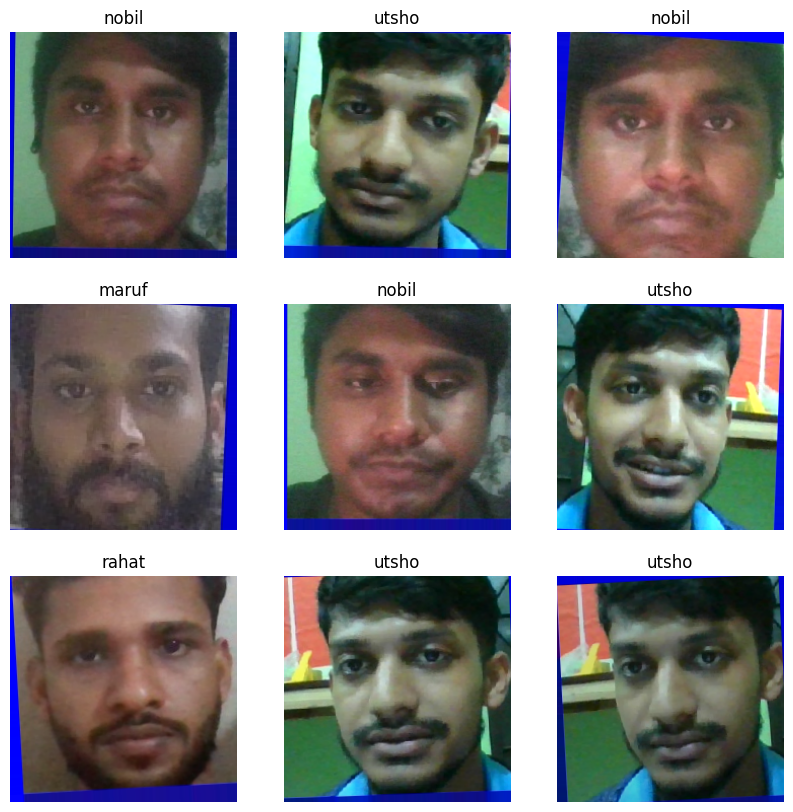

In [6]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    class_index = np.argmax(labels[i])
    class_label = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(class_index)]
    plt.title(class_label)
    plt.axis("off")
plt.show()

# Downloading the base model

In [7]:
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Customizing the model

In [8]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # More regularization
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [9]:
initial_lr = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)
optimizer = Adam(learning_rate=lr_schedule)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
h = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 3409s 13s/step - accuracy: 0.6365 - loss: 0.9896 - val_accuracy: 0.9917 - val_loss: 0.0272 - learning_rate: 1.0000e-04
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 142s 540ms/step - accuracy: 0.9848 - loss: 0.0709 - val_accuracy: 0.9979 - val_loss: 0.0079 - learning_rate: 1.0000e-04
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 141s 535ms/step - accuracy: 0.9932 - loss: 0.0328 - val_accuracy: 0.9992 - val_loss: 0.0035 - learning_rate: 1.0000e-04
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 140s 533ms/step - accuracy: 0.9954 - loss: 0.0186 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 1.0000e-04
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 139s 530ms/step - accuracy: 0.9948 - loss: 0.0141 - val_accuracy: 1.0000 - val_loss: 9.0151e-04 - learning_rate: 1.0000e-04
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 143s 535ms/step - accuracy: 0.9958 - loss: 0.0131 - val_accuracy: 1.0000 - val_loss: 7.7886e-04 - learning_rate: 1.0000e-04
Epoch 7/10
263/263 ━━━━━━━━━━━━━━

# Model evaluation

In [11]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

38/38 ━━━━━━━━━━━━━━━━━━━━ 402s 11s/step - accuracy: 1.0000 - loss: 4.1070e-04
Test Accuracy: 100.00%


In [12]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

print("Classification Report:")
print(classification_report(test_generator.classes, y_pred, target_names=list(test_generator.class_indices.keys())))

print("Confusion Matrix:")
print(confusion_matrix(test_generator.classes, y_pred))

38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step
Classification Report:
              precision    recall  f1-score   support

       maruf       1.00      1.00      1.00       300
       nobil       1.00      1.00      1.00       300
       rahat       1.00      1.00      1.00       300
       utsho       1.00      1.00      1.00       300

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200

Confusion Matrix:
[[300   0   0   0]
 [  0 300   0   0]
 [  0   0 300   0]
 [  0   0   0 300]]


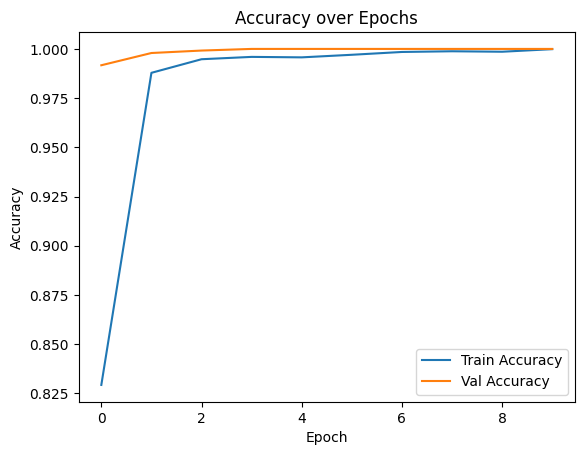

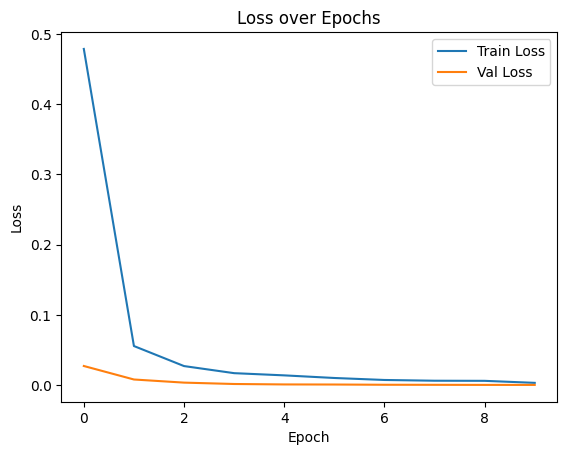

In [13]:
# Accuracy
plt.plot(h.history['accuracy'], label='Train Accuracy')
plt.plot(h.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(h.history['loss'], label='Train Loss')
plt.plot(h.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


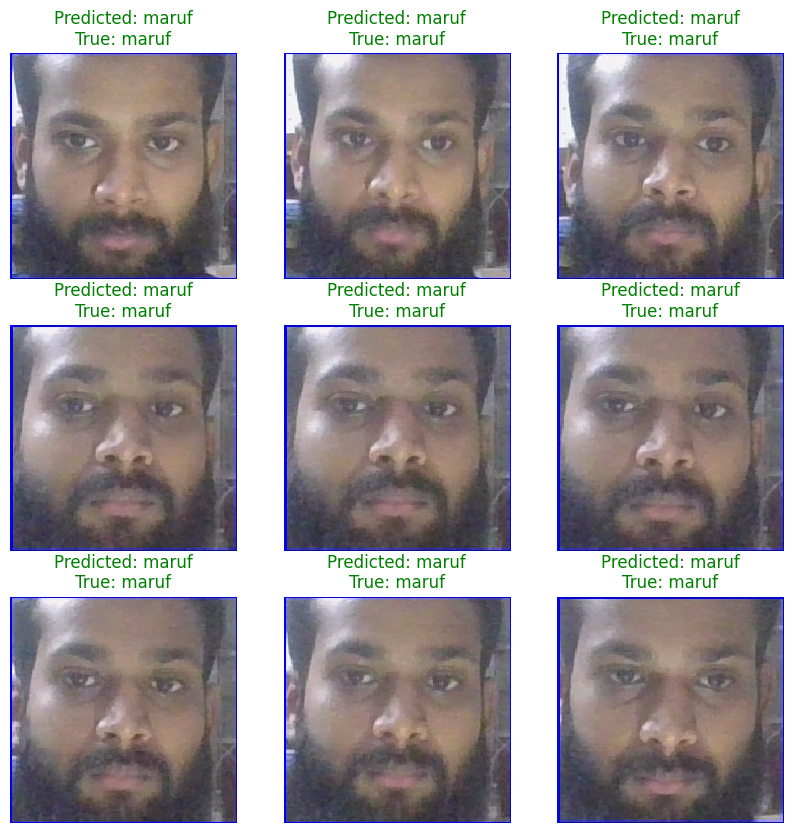

In [14]:
test_images, test_labels = next(test_generator)
predictions = model.predict(test_images)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i])
    predicted_class_index = np.argmax(predictions[i])
    true_class_index = np.argmax(test_labels[i])

    predicted_class_label = list(test_generator.class_indices.keys())[list(test_generator.class_indices.values()).index(predicted_class_index)]
    true_class_label = list(test_generator.class_indices.keys())[list(test_generator.class_indices.values()).index(true_class_index)]

    title_color = "green" if predicted_class_index == true_class_index else "red"
    plt.title(f"Predicted: {predicted_class_label}\nTrue: {true_class_label}", color=title_color)
    plt.axis("off")
plt.show()

In [15]:
print("Label mapping:", train_generator.class_indices)

Label mapping: {'maruf': 0, 'nobil': 1, 'rahat': 2, 'utsho': 3}


In [16]:
from google.colab import files

model_save_path = "tr_mobilenetv3.h5"
model.save(model_save_path)

files.download(model_save_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>